<a href="https://colab.research.google.com/github/MWali94/detect_face_gender_age/blob/main/faceGenderAgeCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)


  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [5]:


def detect_face_gender_age(image_path):
    # Paths to the models and configuration files and set mean values
    face1 = "/content/drive/MyDrive/drive-download-20240515T120929Z-001/opencv_face_detector.pbtxt"
    face2 = "/content/drive/MyDrive/drive-download-20240515T120929Z-001/opencv_face_detector_uint8.pb"
    age1 = "/content/drive/MyDrive/drive-download-20240515T120929Z-001/age_deploy.prototxt"
    age2 = "/content/drive/MyDrive/drive-download-20240515T120929Z-001/age_net.caffemodel"
    gen1 = "/content/drive/MyDrive/drive-download-20240515T120929Z-001/gender_deploy.prototxt"
    gen2 = "/content/drive/MyDrive/drive-download-20240515T120929Z-001/gender_net.caffemodel"

    # Mean values for the model
    MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

    # Using models
    # Face
    face = cv2.dnn.readNet(face2, face1)

    # age
    age = cv2.dnn.readNet(age2, age1)

    # gender
    gen = cv2.dnn.readNet(gen2, gen1)

    # Age and gender labels Categories of distribution
    la = ['(0-2)', '(4-6)', '(8-12)', '(15-20)',
          '(25-32)', '(38-43)', '(48-53)', '(60-100)']
    lg = ['Male', 'Female']

    # Copy image
    fr_cv = cv2.imread(image_path)

    # Face detection
    fr_h = fr_cv.shape[0]
    fr_w = fr_cv.shape[1]
    blob = cv2.dnn.blobFromImage(fr_cv, 1.0, (300, 300),
                                 [104, 117, 123], True, False)

    face.setInput(blob)
    detections = face.forward()

    # Face bounding box creation
    faceBoxes = []
    for i in range(detections.shape[2]):

        # Bounding box creation if confidence > 0.7
        confidence = detections[0, 0, i, 2]
        if confidence > 0.7:

            x1 = int(detections[0, 0, i, 3]*fr_w)
            y1 = int(detections[0, 0, i, 4]*fr_h)
            x2 = int(detections[0, 0, i, 5]*fr_w)
            y2 = int(detections[0, 0, i, 6]*fr_h)

            faceBoxes.append([x1, y1, x2, y2])

            cv2.rectangle(fr_cv, (x1, y1), (x2, y2),
                          (0, 255, 0), int(round(fr_h/150)), 8)

    # Checking if face detected or not
    if not faceBoxes:
        print("No face detected")
        return None

    # Final results (otherwise)
    # Loop for all the faces detected
    for faceBox in faceBoxes:

        # Extracting face as per the faceBox
        face_roi = fr_cv[max(0, faceBox[1]-15):
                          min(faceBox[3]+15, fr_cv.shape[0]-1),
                          max(0, faceBox[0]-15):min(faceBox[2]+15,
                                        fr_cv.shape[1]-1)]

        # Extracting the main blob part
        blob = cv2.dnn.blobFromImage(
            face_roi, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        # Prediction of gender
        gen.setInput(blob)
        genderPreds = gen.forward()
        gender = lg[genderPreds[0].argmax()]

        # Prediction of age
        age.setInput(blob)
        agePreds = age.forward()
        age_pred = la[agePreds[0].argmax()]

        # Putting text of age and gender, At the top of box
        cv2.putText(fr_cv,
                    f'{gender}, {age_pred}',
                    (faceBox[0]-150, faceBox[1]+10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.3,
                    (217, 0, 0),
                    4,
                    cv2.LINE_AA)

    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(fr_cv, cv2.COLOR_BGR2RGB))
    plt.show()



<IPython.core.display.Javascript object>

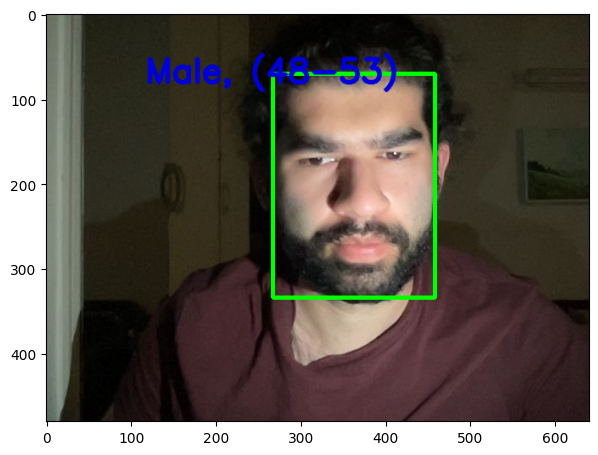

Saved to None
No image data found. Expecting filename, url, or data.


In [9]:
from IPython.display import Image
try:
  filename = detect_face_gender_age(take_photo())
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
